In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
def format_stars(stars):

    stars = stars.split(', \'')
    stars = [star for star in stars if star != '' and ':\'' not in star]
    stars[0] = stars[0][2:]
    stars[-1] = stars[-1][:-2]

    dir_index = -1
    for j in range(len(stars)):
        stars[j] = stars[j].replace(', "', '')
        if ':\'' in stars[j]:
            stars[j] = stars[j].split(':\'')[1]
        if '|' in stars[j]:
            dir_index = j
    
    stars = stars[dir_index + 1:]

    if stars == ['']:
        stars = []

    return stars if stars != [] else None

def format_genres(genre):
    genres = genre.split(', ')
    return genres if genres != [] else None

def format_years(year):
    if len(year) < 5 or year[1] not in ['1', '2']:
        return None
    return int(year[1:5])

def format_votes(votes):
    if (type(votes) == str):
        votes = votes.replace(",", "")
        votes = float(votes)
    return votes

def set_is_tv(duration):
    duration = int(duration[0: -4])

    if duration < 70:
        return True
    return False

def get_cleaned_dataframe():
    df = pd.read_csv('./n_movies.csv')
    df = df.drop(columns=['description', 'certificate'])
    df = df.dropna(subset=['stars', 'duration', 'year', 'genre'])
    df = df.drop_duplicates(subset=['title'])

    df['stars'] = df['stars'].apply(format_stars)
    df['genre'] = df['genre'].apply(format_genres)
    df['year'] = df['year'].apply(format_years)
    df['is_tv'] = df['duration'].apply(set_is_tv)
    df['votes'] = df['votes'].apply(format_votes)
    
    df = df.dropna()
    df = df.reset_index()
    
    return df



In [ ]:
df = get_cleaned_dataframe()

def get_top_media(df, n):
    # Creating dataframes of the top 500 rows sorted by number of votes
    top_media = media.sort_values(by='votes', ascending=False).iloc[:n]
    top_actors = []
    for _, row in top_media.iterrows():
        for star in row['stars']:
            if star not in top_actors:
                top_actors.append(star)
    return top_media

def get_unique_actors(df):
    actors = []
    for _, row in df.iterrows():
        for star in row['stars']:
            if star not in actors:
                actors.append(star)

    return actors


# Making seperate dataframes for movies, tv shows, and combined
movies = df.where(df['is_tv'] == False).dropna().reset_index(drop=True)
tv_shows = df.where(df['is_tv'] == True).dropna().reset_index(drop=True)
media = df.dropna().reset_index(drop=True)


# Creating lists of the actors found in the media
tv_actors = get_unique_actors(tv_shows)

movie_actors = get_unique_actors(movies)

media_actors = get_unique_actors(media)

all_actors = get_unique_actors(df)

all_genres = []
for _, row in df.iterrows():
    for genre in row['genre']:
        if genre not in all_genres:
            all_genres.append(genre)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyvis.network import Network

colors = {000: "#FF8AA7",
    196: "#FFBB8A",
    197: "#F5FF8A",
    198: "#ACFF8A",
    199: "#8AF0FF",
    200: "#8A99FF",
    201: "#D18AFF",
    202: "#FF8ADF"}

# Network Visualization of Media with shared actors
def create_media_network(df, network, num_nodes):
   
    # Creating Nodes
    for i in tqdm(range(num_nodes)):
        year = df.loc[i, 'year']
        year = int(str(year)[:3])
        if year not in colors:
            year=000
        network.add_node(df.loc[i,'title'], color=colors[year])

    # Creating Edges
    for i in tqdm(range(num_nodes)):
        for j in range(i + 1, num_nodes):
            w = 0
            if (df.loc[i, 'stars'] != []):
                for actor in df.loc[i, 'stars']:
                    if actor in df.loc[j, 'stars']:
                        if w == 0:
                            w += 2
                        else:
                            w += 10
            if w > 0:
                network.add_edge(df.loc[i, 'title'], df.loc[j, 'title'], weight=w, color='#868686')
    return network

# Creating the networks
movie_network = nx.MultiGraph()
tv_show_network = nx.MultiGraph()
combine_network = nx.MultiGraph()

movie_network = create_media_network(movies, movie_network, len(movies))
tv_show_network = create_media_network(tv_shows, tv_show_network, len(tv_shows))
combine_network = create_media_network(media, combine_network, len(media))

# Scaling the nodes based on their degree
scale=10
d_movie = dict(movie_network.degree)
d_movie.update((x, scale*y) for x, y in d_movie.items())
d_tv_show = dict(tv_show_network.degree)
d_tv_show.update((x, scale*y) for x, y in d_tv_show.items())
d_combine = dict(combine_network.degree)
d_combine.update((x, scale*y) for x, y in d_combine.items())

# Setting up size attribute
nx.set_node_attributes(movie_network, d_movie,'size')
nx.set_node_attributes(tv_show_network, d_tv_show,'size')
nx.set_node_attributes(combine_network, d_combine,'size')

# Creating the Pyvis Networks
nt_movie = Network("1000px", "1000px")
nt_tv_show = Network("1000px", "1000px")
nt_combine = Network("1000px", "1000px")

nt_movie.from_nx(movie_network)
nt_tv_show.from_nx(tv_show_network)
nt_combine.from_nx(combine_network)

nt_movie.show_buttons(filter_='physics')
nt_tv_show.show_buttons(filter_='physics')
nt_combine.show_buttons(filter_='physics')

nt_movie.show("nx_movie.html")
nt_tv_show.show("nx_tv_show.html")
nt_combine.show("nx_combine.html")


In [ ]:
# Getting data from specific nodes we find interesting
# Movies
# Johan Falk
print(movie_network.degree['Johan Falk: Barninfiltratören'])
print(movie_network.degree['Johan Falk: Ur askan i elden'])
print(movie_network.degree['Johan Falk: National Target'])
print(movie_network.degree['Johan Falk: Slutet'])
print(movie_network.degree['Johan Falk: Lockdown'])
print(movie_network.degree['Labrador'])
# Jumanji
print(movie_network.degree['Jumanji: Welcome to the Jungle'])
# TV Shows 
# Children of the Whales
# Kuromukuro

In [ ]:
# Media Visualization of Actors with Shared Media

def create_actor_network(actors, df, network, num_nodes):
    # Creating Nodes
    for actor in range(num_nodes):
        network.add_node(actors[actor])

    # Creating Edges
    for i in range(num_nodes):
        for j in range(len(df)):
            if actors[i] in df.loc[j, 'stars']:
                for actor_2 in df.loc[j, 'stars']:
                    if (actor_2 != actors[i]) and (actor_2 in actors):
                        w=1
                        if (network.has_edge(actors[i], actor_2)):
                            e = network.get_edge_data(actors[i], actor_2)
                            w += e[0]["weight"]
                            w += 2
                            network.remove_edge(actors[i], actor_2)
                            
                        network.add_edge(actors[i], actor_2, weight=w, color='#868686')
    return network

movie_actor_network = nx.MultiGraph()
movie_actor_network = create_actor_network(movie_actors, movies, movie_actor_network, len(movie_actors))

tv_actor_network = nx.MultiGraph()
tv_actor_network = create_actor_network(tv_actors, tv_shows, tv_actor_network, len(tv_actors))

media_actor_network = nx.MultiGraph()
media_actor_network = create_actor_network(media_actors, media, media_actor_network, len(media_actors))

# Scaling the nodes based on their degree
scale=15
d_movie_actor = dict(movie_actor_network.degree)
d_movie_actor.update((x, scale*y) for x, y in d_movie_actor.items())

d_tv_actor = dict(tv_actor_network.degree)
d_tv_actor.update((x, scale*y) for x, y in d_tv_actor.items())

d_media_actor = dict(media_actor_network.degree)
d_media_actor.update((x, scale*y) for x, y in d_media_actor.items())

# Setting up size attribute
nx.set_node_attributes(movie_actor_network, d_movie_actor,'size')
nx.set_node_attributes(tv_actor_network, d_tv_actor,'size')

nx.set_node_attributes(media_actor_network, d_media_actor,'size')
nx.set_node_attributes(media_actor_network, d_media_actor,'size')
# Converting to Pyvis Network
nt_movie_actor = Network("1000px", "1000px")
nt_movie_actor.from_nx(movie_actor_network)
nt_movie_actor.show_buttons(filter_='physics')
nt_movie_actor.show("nx_movie_actor.html")

nt_tv_actor = Network("1000px", "1000px")
nt_tv_actor.from_nx(tv_actor_network)
nt_tv_actor.show_buttons(filter_='physics')
nt_tv_actor.show("nx_tv_actor.html")

nt_media_actor = Network("1000px", "1000px")
nt_media_actor.from_nx(media_actor_network)
nt_media_actor.show_buttons(filter_='physics')
nt_media_actor.show("nx_media_actor.html")

# Getting info about nodes we find interesting

In [ ]:
# Getting info about nodes we find interesting
# Ashleigh Ball
# Cherami Leigh
# Dee Bradley Baker
# Johnny Yong Bosch
# Teresa Gallagher
# Todd Haberkorn
# Will Arnet

In [ ]:
def get_genre_v_rating(df):
    genre_ratings_dict = {}

    for _, row in df.iterrows():
        for genre in row['genre']:
            if genre not in genre_ratings_dict:
                genre_ratings_dict[genre] = []
            genre_ratings_dict[genre].append(row['rating'])

    genre_df = pd.DataFrame()

    for genre in genre_ratings_dict:
        ratings = genre_ratings_dict[genre]

        genre_df.loc[genre, 'mean'] = np.mean(ratings)
        genre_df.loc[genre, 'std'] = np.std(ratings)
        genre_df.loc[genre, 'count'] = len(ratings)

    return genre_df

def get_genres_per_actor(df):
    actor_df = pd.DataFrame(index=get_unique_actors(df), columns=all_genres)

    actor_df = actor_df.infer_objects(copy=False).fillna(0)

    for _, row in df.iterrows():
        for actor in row['stars']:
            for genre in row['genre']:
                actor_df.loc[actor, genre] += 1;

    media_per_actor_by_genre_df = pd.DataFrame()

    for genre in actor_df.columns:
        counts = [count for count in actor_df[genre] if count != 0] 
        if counts != []:
            media_per_actor_by_genre_df.loc[genre, 'mean'] = np.mean(counts) 
            media_per_actor_by_genre_df.loc[genre, 'std'] = np.std(counts)
            media_per_actor_by_genre_df.loc[genre, 'count'] = len(counts)
    
    return media_per_actor_by_genre_df

def get_actor_ratings(df):
    actor_ratings_dict = {}

    for _, row in df.iterrows():
        for actor in row['stars']:
            if actor not in actor_ratings_dict:
                actor_ratings_dict[actor] = []
            actor_ratings_dict[actor].append(row['rating'])

    actor_ratings_df = pd.DataFrame(index=actor_ratings_dict.keys())

    for actor in actor_ratings_dict:
        actor_ratings_df.loc[actor, 'mean'] = np.mean(actor_ratings_dict[actor])
        actor_ratings_df.loc[actor, 'std'] = np.std(actor_ratings_dict[actor])
        actor_ratings_df.loc[actor, 'count'] = len(actor_ratings_dict[actor])

    return actor_ratings_df
            


def plot_mean_std(df, title, xlabel, ylabel, ylim=0):
    df = df.drop(df.loc[df['count'] == 0].index)

    df = df.sort_index(axis=0)

    plt.figure(figsize=(30, 10))
    plt.bar(x=df.index, height=df['mean'])
    plt.errorbar(range(len(df)), df['mean'], yerr=df['std'], fmt='or')
    plt.xlim(-.5,len(df)-.5)
    if (ylim != 0):
        plt.ylim(0, ylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [ ]:
combined_genre_df = get_genre_v_rating(df)
tv_genre_df = get_genre_v_rating(df.drop(df.loc[df['is_tv'] != True].index))
movie_genre_df = get_genre_v_rating(df.drop(df.loc[df['is_tv'] != False].index))

plot_mean_std(combined_genre_df, 'Combined', 'Genre', 'Rating', 10)
plot_mean_std(tv_genre_df, 'TV', 'Genre', 'Rating', 10)
plot_mean_std(movie_genre_df, 'Movies', 'Genre', 'Rating', 10)

In [ ]:
media_per_actor_by_genre_df = get_genres_per_actor(df)
tv_shows_per_actor_by_genre_df = get_genres_per_actor(df.drop(df.loc[df['is_tv'] != True].index))
movies_per_actor_by_genre_df = get_genres_per_actor(df.drop(df.loc[df['is_tv'] != False].index))

plot_mean_std(media_per_actor_by_genre_df, 'Combined', 'Genre', 'Media per actor', 3.5)
plot_mean_std(tv_shows_per_actor_by_genre_df, 'TV Shows', 'Genre', 'Media per actor', 3.5)
plot_mean_std(movies_per_actor_by_genre_df, 'Movies', 'Genre', 'Media per actor', 3.5)

In [ ]:
for i in range(1930, 2030, 10):
    decade_df = df.drop(df.loc[df['year'] < i].index) 
    decade_df = decade_df.drop(df.loc[df['year'] >= i+10].index) 
    media_per_actor_by_genre_by_decade_df = get_genres_per_actor(decade_df)
    plot_mean_std(media_per_actor_by_genre_by_decade_df, f'{i}\'s', 'Genre', 'Media per actor', 3.5)

In [ ]:
for i in range(1930, 2030, 10):
    decade_df = df.drop(df.loc[df['year'] < i].index) 
    decade_df = decade_df.drop(df.loc[df['year'] >= i+10].index) 
    genre_v_rating_by_decade_df = get_genre_v_rating(decade_df) 
    plot_mean_std(genre_v_rating_by_decade_df, f'{i}\'s', 'Genre', 'Rating', 10)

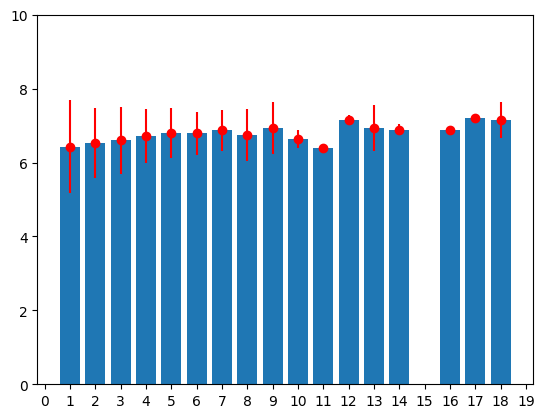

In [39]:
actor_ratings_df = get_actor_ratings(df).sort_values('count', ascending=False)

count_ratings_dict = {}

for _, row in actor_ratings_df.iterrows():
    if row['count'] not in count_ratings_dict:
        count_ratings_dict[row['count']] = []
    count_ratings_dict[row['count']].append(row['mean'])

means = []
stds = []

for i in count_ratings_dict:
    means.append(np.mean(count_ratings_dict[i]))
    stds.append(np.std(count_ratings_dict[i]))

fig, ax = plt.subplots()

plt.bar(count_ratings_dict.keys(), means)

plt.errorbar(count_ratings_dict.keys(), means, yerr=stds, fmt='or')
plt.ylim(0, 10)
plt.xticks(np.arange(0, 20, step=1))
plt.show()